In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# coordinates_list = [[0.9, 0.9],
#                     [0.8, 1],
#                     [0.9, 1.1],
#                     [1, 1]]


# a = ([[  6.48076197,   9.86263944,  -0.27829966],
#        [  5.51923803,  10.13736056,  -0.27829966],
#        [  7.14367394,   7.47891314,   1.27933953],
#        [  6.85632606,   6.52108686,   1.27933953],
#        [ 10.48809353,  10.10846523,  -2.92292371],
#        [  9.51190647,   9.89153477,  -2.92292371],
#        [  8.08219949,  11.49319696,  -1.735945  ],
#        [  7.91780051,  10.50680304,  -1.735945  ]])

# print(filter_outer(a))

In [3]:
def get_rt(alpha, x):
    s, c = np.sin(alpha), np.cos(alpha)
    r = np.array([[c, s], [-s, c]])
    rotated = np.dot(r, x)
    return rotated

def calculate_distance(coords1, coords2):
    theta_diff = None
    distance_map_frame = coords2[:2] - coords1[:2]
    if len(coords1) == 3 and len(coords2) == 3:
        theta_diff = wrap_angle(coords2[2] - coords1[2])
    return distance_map_frame, theta_diff

def wrap_angle(angle):
    """
    Wraps the given angle to the range [-pi, +pi].
    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """
    return (angle + np.pi) % (np.pi * 2) - np.pi

def rotate(a, b, c):
    return (b[0] - a[0]) * (c[1] - b[1]) - (b[1] - a[1]) * (c[0] - b[0])

def find_outer(coords):
    """
    filter out inner landings
    input: [(x0, y0), (x1, y1), ...]
    jarvis march
    :return: convex hull, list of coordinates, TODO counter or clockwise, need to figure out
    """
    a = coords
    n = len(a)
    p = range(n)
    # start point
    for i in range(1, n):
        if a[p[i]][0] < a[p[0]][0]:
            p[i], p[0] = p[0], p[i]
    h = [p[0]]
    del p[0]
    p.append(h[0])
    while True:
        right = 0
        for i in range(1, len(p)):
            if rotate(a[h[-1]], a[p[right]], a[p[i]]) < 0:  # FIXME
                right = i
        if p[right] == h[0]:
            break
        else:
            h.append(p[right])
            del p[right]
    #hull = [a[i] for i in h]
    return h

def transformation_matrix(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])

def plot_vehicle(x, y, theta):
    # Corners of triangular vehicle when pointing to the right (0 radians)

    p1_i = np.array([0.03, 0, 1]).T
    p2_i = np.array([-0.02, 0.01, 1]).T
    p3_i = np.array([-0.02, -0.01, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-')
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], 'g-')
    ax.plot([p3[0], p1[0]], [p3[1], p1[1]], 'g-')

In [4]:
# pucks_in_frame = np.array([[0.6, 0.10], [0.7, 0.7], [0.10, 0.10], [0.8, 0.11]])

pucks_in_frame = np.array([[0.7, 0.8],
                            [0.9, 0.9],
                            [1.1, 0.85],
                            [0.9, 1.1]])

# hull = [[9, 9],
#         [8, 10],
#         [9, 11],
#         [10, 10]]

# rot_hull = [get_rt(0, node) for node in hull]
# rot_hull = np.array(rot_hull)

# pucks_in_frame = np.array([[0.93900626, 0.99461677],
#                              [1.04959243, 1.00593718],
#                              [1.05693593, 1.12152614],
#                              [0.94454928, 1.14355901]])

# pucks_in_frame = np.array([[0.93900626, 0.99461677],
#                              [1.04959243, 1.00593718],
#                              [1.05693593, 1.12152614]])

ind = find_outer(pucks_in_frame)
rot_hull = np.array([pucks_in_frame[i] for i in ind])

approach_dist = 0.11  # cm
mc = np.mean(rot_hull, axis = 0)
offset = list(rot_hull)  # a miserable attempt to copy a list
offset -= mc  # Normalize the polygon by subtracting the center values from every point.
offset *= 2
offset += mc

In [5]:
landings_coordinates = []
for orig, ofs in zip(rot_hull, offset):
#     print(" ")
#     print("orig")
#     print(orig)
#     print(" ")
#     print("ofs")
#     print(ofs)
    dist, _ = calculate_distance(ofs, orig)
#     print(dist)
    gamma = np.arctan2(dist[1], dist[0])  # and here we calculate slope of outer bis
    # print("gamma = ", np.rad2deg(gamma))
    x_landing1 = np.sqrt(approach_dist**2 / (1 + np.tan(gamma)**2))
    x_landing2 = - np.sqrt(approach_dist**2 / (1 + np.tan(gamma)**2))
    
    y_landing1 = np.tan(gamma) * x_landing1 
    y_landing2 = np.tan(gamma) * x_landing2
    
    landing1 = np.array([x_landing1 + orig[0], y_landing1 + orig[1], gamma])  # np.rad2deg
    landing2 = np.array([x_landing2 + orig[0], y_landing2 + orig[1], gamma])
    landings_coordinates.append(landing1)
    landings_coordinates.append(landing2)
    
landings = np.array(landings_coordinates)
# print(landings)
ind_land = find_outer(landings[:, :2])
# print(ind_land)
landings = np.array([landings_coordinates[i] for i in ind_land])

In [6]:
test = np.array([[0.812, 0.834, 0.64350111], 
                [0.85532477, 1.20051927, 5.13061331],
                [1.188, 0.784, 2.49809154]])

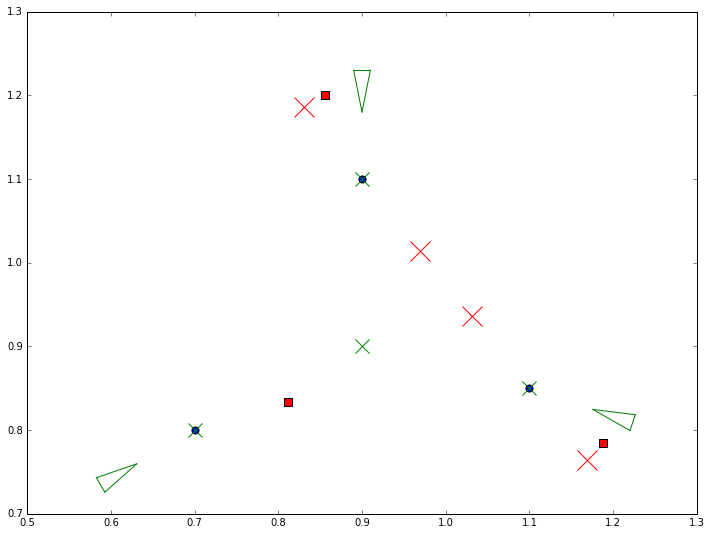

In [12]:
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

# ax.scatter(offset[:, 0], offset[:, 1], c = "r", marker="s",  s=50)
ax.scatter(test[:, 0], test[:, 1], c = "r", marker="s",  s=50)

# ax.scatter(hull[:, 0], hull[:, 1], c = "r")

ax.scatter(rot_hull[:, 0], rot_hull[:, 1], c = "b", marker="o",  s=50)
ax.scatter(pucks_in_frame[:, 0], pucks_in_frame[:, 1], c = "g", marker="x",  s=200)
ax.scatter(candidates[:, 0], candidates[:, 1], c = "r", marker="x",  s=400)

for landing in landings:
    # print(landing)
    x = landing[0]
    y = landing[1]
    theta = landing[2]
    # print(theta)
    plot_vehicle(x, y, theta)

# for rot, ofs in zip(rot_hull, offset):
#     # print(rot, ofs)
#     x = [rot[0], ofs[0]]
#     y = [rot[1], ofs[1]]
#     ax.plot(x, y)

# landings2 = list(landings)
# for i in landings2:
#     print("i is")
#     print(i)
#     print("")
    #ax.plot(k+mc[0], np.tan(i[2])*k+mc[1])
    
#ax.scatter(offset[:, 0], offset[:, 1], c = "y")
ax.set_aspect('equal')
plt.show()

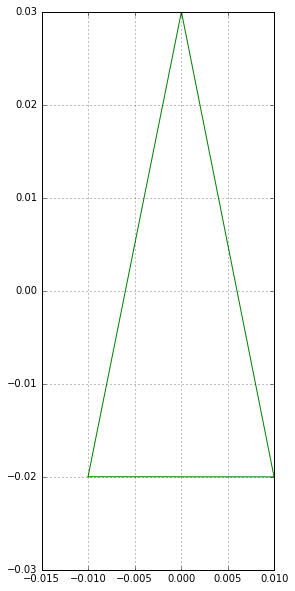

In [8]:
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

landing = np.array([0, 0, 1.57])
x = landing[0]
y = landing[1]
theta = landing[2]
    
plot_vehicle(x, y, theta)

ax.set_aspect('equal')
plt.grid()
plt.show()

In [9]:
# from math import tan
# fig = plt.gcf()
# fig, ax = plt.subplots()
# for i in landings2:
#     print("i is")
#     print(tan(i[2]))
#     print("")
#     ax.plot(t+mc[0], tan(i[2])*t+mc[1])
    
# #ax.scatter(offset[:, 0], offset[:, 1], c = "y")

# plt.show()

            # a = self.known_coords_of_chaos_pucks
            # b = self.sorted_chaos_landing_coordinates
            # a, b = self.execute_current_puck_cmd(a, b)
            # this doesn't work

In [3]:
candidates = np.array([[ 0.83128354,  1.18589557,  5.38712992], 
                         [ 0.96871646,  1.01410443,  5.38712992], 
                         [ 1.16871646,  0.76410443,  2.24553727], 
                         [ 1.03128354,  0.93589557,  2.24553727]])

In [13]:
candidates[:, :2]

array([[ 0.83128354,  1.18589557],
       [ 0.96871646,  1.01410443],
       [ 1.16871646,  0.76410443],
       [ 1.03128354,  0.93589557]])

In [20]:
indexes = []
test = list(candidates[:, :2])
test.sort(key = lambda (t, k): t**2 + k**2)
# landing_max = candidates[:, :2].sort(key = lambda t, k: t**2 + k**2, reverse=True)
indexes.append(test[0])
indexes.append(test[-1])
indexes

[array([ 1.03128354,  0.93589557]), array([ 0.83128354,  1.18589557])]

In [39]:
def wrap_angle(angle):

    """
    Wraps the given angle to the range [-pi, +pi].
    :param angle: The angle (in rad) to wrap (can be unbounded).
    :return: The wrapped angle (guaranteed to in [-pi, +pi]).
    """

    return (angle + np.pi) % (2 * np.pi) - np.pi


def wrap_back(angle):
    """
    :param angle: (-pi, pi)
    :return: (0, 2*pi)
    """
    return (angle + 2 * np.pi) % (2 * np.pi)


def calculate_distance(coords1, coords2):
    """
    Calculates x_diff, y_diff between two points
    Calculates x_diff, y_diff and theta_diff between two vectors and wrapes angle so it lies
    :param coords1:
    :param coords2:
    :return:
    """
    #print(coords1)
    #print(coords2)
    theta_diff = None
    # distance_map_frame = coords2[:2] - coords1[:2]
    distance_map_frame = coords2[:, :2] - coords1[:, :2]

    if len(coords1) == 3 and len(coords2) == 3:
        theta_diff = wrap_angle(coords2[2] - coords1[2])
    return distance_map_frame, theta_diff

In [20]:
coords = np.array([[0.7, 0.8, 0, 0],
                    [0.8, 0.9, 1, 0],
                    [0.9, 0.85, 2, 0],
                    [1, 1.1, 3, 0]])

наоборот

103
210
321
032

In [7]:
a = np.roll(pucks_in_frame, 1, axis=0)
a

array([[0.9 , 1.1 , 3.  , 0.  ],
       [0.7 , 0.8 , 0.  , 0.  ],
       [0.9 , 0.9 , 1.  , 0.  ],
       [1.1 , 0.85, 2.  , 0.  ]])

In [85]:
def calc_inner_angles(coords):
    next_ = np.roll(coords, -1, axis=0)
    prev_ = np.roll(coords, 1, axis=0)
    prev_dist, _ = calculate_distance(coords[:, :2], prev_[:, :2])
    next_dist, _ = calculate_distance(coords[:, :2], next_[:, :2])
    prev_a = np.arctan2(prev_dist[:, 1], prev_dist[:, 0])
    next_a = np.arctan2(next_dist[:, 1], next_dist[:, 0])
    angles = wrap_angle(prev_a - next_a)
    #angles = next_a - prev_a

    coords_angles = list(zip(coords, angles))
    coords_angles.sort(key = lambda t: t[1])
    
    # coords_angles = np.array(coords_angles)
    print("coords")
    print(coords)
    
    print("prev_")
    #print(prev_)
    print(prev_[:, :2])
    print("next")
    print(next_)
    
    print(" ")
    print("prev_dist")
    print(prev_dist)
    print("prev_dist[:, 1]")
    print(prev_dist[:, 1])
    print(" ")
    print("next_dist")
    print(next_dist)
    
    print("prev_a")
    print(prev_a)

    return coords_angles

In [84]:
c = calc_inner_angles(coords)
c

coords
[[0.7  0.8  0.   0.  ]
 [0.8  0.9  1.   0.  ]
 [0.9  0.85 2.   0.  ]
 [1.   1.1  3.   0.  ]]
prev_
[[1.   1.1 ]
 [0.7  0.8 ]
 [0.8  0.9 ]
 [0.9  0.85]]
next
[[0.8  0.9  1.   0.  ]
 [0.9  0.85 2.   0.  ]
 [1.   1.1  3.   0.  ]
 [0.7  0.8  0.   0.  ]]
 
prev_dist
[[-0.3  -0.3 ]
 [ 0.1   0.1 ]
 [ 0.1  -0.05]
 [ 0.1   0.25]]
prev_dist[:, 1]
[-0.3   0.1  -0.05  0.25]
 
next_dist
[[ 0.1   0.1 ]
 [ 0.1  -0.05]
 [ 0.1   0.25]
 [-0.3  -0.3 ]]
prev_a
[-2.35619449  0.78539816 -0.46364761  1.19028995]


[(array([0.7, 0.8, 0. , 0. ]), -3.1415926535897927),
 (array([1. , 1.1, 3. , 0. ]), -2.7367008673047097),
 (array([0.9 , 0.85, 2.  , 0.  ]), -1.6539375586833385),
 (array([0.8, 0.9, 1. , 0. ]), 1.2490457723982544)]

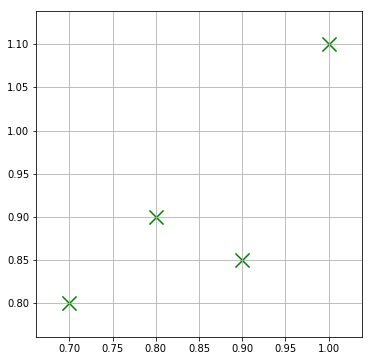

In [51]:
a = coords[:, :2]

def transformation_matrix(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                     [np.sin(theta), np.cos(theta), y],
                     [0, 0, 1]])

def plot_vehicle(x, y, theta):
    # Corners of triangular vehicle when pointing to the right (0 radians)

    p1_i = np.array([0.03, 0, 1]).T
    p2_i = np.array([-0.02, 0.01, 1]).T
    p3_i = np.array([-0.02, -0.01, 1]).T

    T = transformation_matrix(x, y, theta)
    p1 = np.matmul(T, p1_i)
    p2 = np.matmul(T, p2_i)
    p3 = np.matmul(T, p3_i)

    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-')
    ax.plot([p2[0], p3[0]], [p2[1], p3[1]], 'g-')
    ax.plot([p3[0], p1[0]], [p3[1], p1[1]], 'g-')
    
fig = plt.gcf()
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

# ax.scatter(offset[:, 0], offset[:, 1], c = "r", marker="s",  s=50)
#ax.scatter(test[:, 0], test[:, 1], c = "r", marker="s",  s=50)

#ax.scatter(rot_hull[:, 0], rot_hull[:, 1], c = "b", marker="o",  s=50)
ax.scatter(a[:, 0], a[:, 1], c = "g", marker="x",  s=200)
#ax.scatter(candidates[:, 0], candidates[:, 1], c = "r", marker="x",  s=400)

# for landing in landings:
#     # print(landing)
#     x = landing[0]
#     y = landing[1]
#     theta = landing[2]
#     # print(theta)
#     plot_vehicle(x, y, theta)
    
#ax.scatter(offset[:, 0], offset[:, 1], c = "y")
ax.set_aspect('equal')
plt.grid()
plt.show()

In [ ]:
[(array([0.7, 0.8, 0. , 0. ]), -3.141592653589793),
 (array([0.8, 0.9, 1. , 0. ]), -1.2490457723982542),
 (array([0.9 , 0.85, 2.  , 0.  ]), 1.6539375586833387),
 (array([1. , 1.1, 3. , 0. ]), 2.7367008673047097)]